In [1]:
import pandas as pd 

In [2]:
prod = pd.read_parquet("./esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet")
prod.head()

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
0,B079VKKJN7,"11 Degrees de los Hombres Playera con Logo, Ne...",Esta playera con el logo de la marca Carrier d...,11 Degrees Negro Playera con logo\nA estrenar ...,11 Degrees,Negro,es
1,B079Y9VRKS,Camiseta Eleven Degrees Core TS White (M),None,None,11 Degrees,Blanco,es
2,B07DP4LM9H,11 Degrees de los Hombres Core Pull Over Hoodi...,La sudadera con capucha Core Pull Over de 11 G...,11 Degrees Azul Core Pull Over Hoodie\nA estre...,11 Degrees,Azul,es
3,B07G37B9HP,11 Degrees Poli Panel Track Pant XL Black,None,None,11 Degrees,None,es
4,B07LCTGDHY,11 Degrees Gorra Trucker Negro OSFA (Talla úni...,None,None,11 Degrees,Negro (,es


In [3]:
quer = pd.read_parquet("./esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet")
quer.head()

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train
3,3,revent 80 cfm,0,B07RH6Z8KW,us,E,0,1,train
4,4,revent 80 cfm,0,B07QJ7WYFQ,us,E,0,1,train


In [4]:
df_examples_products = pd.merge(
    quer,
    prod,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
df_examples_products.head()

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,None,WhisperCeiling fans feature a totally enclosed...,Panasonic,White
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train,Homewerks 7141-80 Bathroom Fan Integrated LED ...,None,OUTSTANDING PERFORMANCE: This Homewerk's bath ...,Homewerks,80 CFM
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train,Homewerks 7140-80 Bathroom Fan Ceiling Mount E...,None,OUTSTANDING PERFORMANCE: This Homewerk's bath ...,Homewerks,White
3,3,revent 80 cfm,0,B07RH6Z8KW,us,E,0,1,train,Delta Electronics RAD80L BreezRadiance 80 CFM ...,This pre-owned or refurbished product has been...,Quiet operation at 1.5 sones\nBuilt-in thermos...,DELTA ELECTRONICS (AMERICAS) LTD.,White
4,4,revent 80 cfm,0,B07QJ7WYFQ,us,E,0,1,train,Panasonic FV-08VRE2 Ventilation Fan with Reces...,None,The design solution for Fan/light combinations...,Panasonic,White


In [6]:
df_examples_products_filter = df_examples_products[(df_examples_products['esci_label']=='E') & (df_examples_products['product_locale']=='us')]

## Step 2: Prepare Data - Extract All Products and Create Evaluation Sample


In [7]:
print("Full Filtered Dataset:")
print(f"Total rows: {len(df_examples_products_filter)}")
print(f"Unique queries: {df_examples_products_filter['query'].nunique()}")
print(f"Unique products: {df_examples_products_filter['product_id'].nunique()}")
print(f"Average products per query: {len(df_examples_products_filter) / df_examples_products_filter['query'].nunique():.2f}")


Full Filtered Dataset:
Total rows: 1247558
Unique queries: 97344
Unique products: 904348
Average products per query: 12.82


In [8]:
import numpy as np

# Get all unique products from the full filtered dataset
df_all_products = df_examples_products_filter[['product_id', 'product_title', 'product_brand', 
                                                'product_description', 'product_bullet_point', 
                                                'product_color', 'product_locale']].drop_duplicates(subset=['product_id'])

print(f"\nTotal unique products for indexing: {len(df_all_products)}")



Total unique products for indexing: 904348


In [9]:
np.random.seed(42)  # For reproducibility

# First, identify queries that have at least 10 relevant items
query_counts = df_examples_products_filter.groupby('query')['product_id'].count()
queries_with_min_10 = query_counts[query_counts >= 10].index.tolist()

print(f"Queries with at least 10 relevant items: {len(queries_with_min_10)} out of {df_examples_products_filter['query'].nunique()}")

# Sample from queries that meet the minimum threshold
sample_queries = np.random.choice(queries_with_min_10, size=min(50, len(queries_with_min_10)), replace=False)

# Filter to get evaluation data (query-product pairs for these queries)
df_eval = df_examples_products_filter[df_examples_products_filter['query'].isin(sample_queries)]

print(f"\nEvaluation Data (before sampling to 500 rows):")
print(f"Sampled {len(sample_queries)} unique queries for evaluation")
print(f"Total query-product pairs: {len(df_eval)}")
print(f"Unique products in eval set: {df_eval['product_id'].nunique()}")

Queries with at least 10 relevant items: 66191 out of 97344

Evaluation Data (before sampling to 500 rows):
Sampled 50 unique queries for evaluation
Total query-product pairs: 809
Unique products in eval set: 809


In [10]:
def create_product_text(row):
    """Combine product fields into a single text for embedding"""
    parts = []
    
    # Add product title (most important)
    if pd.notna(row.get('product_title')):
        parts.append(str(row['product_title']))
    
    # Add product brand
    if pd.notna(row.get('product_brand')):
        parts.append(f"Brand: {row['product_brand']}")
    
    # Add product description if available (truncate to 500 chars)
    if pd.notna(row.get('product_description')):
        desc = str(row['product_description'])  # Slice the STRING
        parts.append(desc)
    
    # Add product bullet points if available (truncate to 500 chars)
    if pd.notna(row.get('product_bullet_point')):
        bullets = str(row['product_bullet_point'])  # Slice the STRING
        parts.append(bullets)
    
    return " | ".join(parts)

# Apply to ALL products for the index
print("Creating product text representations for ALL products...")
print(f"Processing {len(df_all_products)} products...")
df_all_products['product_text'] = df_all_products.apply(create_product_text, axis=1)

# Show an example
print("\nExample product text:")
print(df_all_products.iloc[0]['product_text'][:300] + "...")


Creating product text representations for ALL products...
Processing 904348 products...

Example product text:
Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM | Brand: Homewerks | OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at ...


In [11]:
# Create product text representations by combining relevant fields
def create_product_text(row):
    """Combine product fields into a single text for embedding"""
    parts = []
    
    # Add product title (most important)
    if pd.notna(row.get('product_title')):
        parts.append(str(row['product_title']))
    
    # Add product brand
    if pd.notna(row.get('product_brand')):
        parts.append(f"Brand: {row['product_brand']}")
    
    # Add product description if available
    if pd.notna(row.get('product_description')):
        desc = str(row['product_description'])
        parts.append(desc)
    
    # Add product bullet points if available
    if pd.notna(row.get('product_bullet_point')):
        parts.append(str(row['product_bullet_point']))
    
    return " | ".join(parts)

# Apply to ALL products for the index
print("Creating product text representations for ALL products...")
print(f"Processing {len(df_all_products)} products...")
df_all_products['product_text'] = df_all_products.apply(create_product_text, axis=1)

# Show an example
print("\nExample product text:")
print(df_all_products.iloc[0]['product_text'][:300] + "...")

Creating product text representations for ALL products...
Processing 904348 products...

Example product text:
Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM | Brand: Homewerks | OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at ...


In [12]:
# # Install required packages
# %pip install lancedb sentence-transformers scikit-learn

## Step 3: Token Length Analysis

Analyze the token length distribution using different embedding model tokenizers to understand truncation impacts.


In [13]:
# Install transformers for tokenizer analysis
# %pip install transformers matplotlib


In [14]:
import torch
torch.cuda.empty_cache()

In [15]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm

print("="*80)
print("TOKEN LENGTH ANALYSIS")
print("="*80)


# Use a sample for faster analysis
SAMPLE_SIZE = 10000
print(f"Total products available: {len(df_all_products):,}")
print(f"Using sample size: {SAMPLE_SIZE:,} products for token analysis")
print("(Token length distribution is representative even with a sample)\n")

# Sample products randomly
df_sample_for_tokens = df_all_products.sample(n=min(SAMPLE_SIZE, len(df_all_products)), random_state=42)

# Load tokenizer once (using any of the models - they're all the same)
print("Loading BERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
print("✓ Tokenizer loaded\n")

# Compute token lengths with progress bar
print(f"Computing token lengths for {len(df_sample_for_tokens):,} products...")
sample_texts = df_sample_for_tokens['product_text'].tolist()
token_lens = []

for text in tqdm(sample_texts, desc="Tokenizing", ncols=100):
    token_lens.append(len(tokenizer.encode(text, truncation=False, add_special_tokens=True)))

# Calculate statistics
token_stats = {
    'mean': np.mean(token_lens),
    'median': np.median(token_lens),
    'p90': np.percentile(token_lens, 90),
    'p95': np.percentile(token_lens, 95),
    'p99': np.percentile(token_lens, 99),
    'max': np.max(token_lens),
    'min': np.min(token_lens),
    'token_lens': token_lens
}

# Print statistics
print("\n" + "="*80)
print("TOKEN LENGTH STATISTICS (applies to ALL BERT-based models)")
print("="*80)
print(f"Mean:            {token_stats['mean']:.1f} tokens")
print(f"Median:          {token_stats['median']:.1f} tokens")
print(f"Min:             {token_stats['min']:.0f} tokens")
print(f"90th percentile: {token_stats['p90']:.0f} tokens")
print(f"95th percentile: {token_stats['p95']:.0f} tokens")
print(f"99th percentile: {token_stats['p99']:.0f} tokens")
print(f"Max:             {token_stats['max']:.0f} tokens")
print()
print("⚠️  TRUNCATION WARNING:")
print(f"   Models have a 512 token limit - longer sequences will be truncated!")
print(f"   ~{(np.array(token_lens) > 512).mean() * 100:.1f}% of products exceed 512 tokens")
print(f"   This affects ~{(np.array(token_lens) > 512).sum():,} out of {len(token_lens):,} sampled products")
print("="*80)


c:\Users\petec\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TOKEN LENGTH ANALYSIS
Total products available: 904,348
Using sample size: 10,000 products for token analysis
(Token length distribution is representative even with a sample)

Loading BERT tokenizer...
✓ Tokenizer loaded

Computing token lengths for 10,000 products...


Tokenizing: 100%|███████████████████████████████████████████| 10000/10000 [00:06<00:00, 1551.37it/s]



TOKEN LENGTH STATISTICS (applies to ALL BERT-based models)
Mean:            288.1 tokens
Median:          207.0 tokens
Min:             3 tokens
90th percentile: 681 tokens
95th percentile: 811 tokens
99th percentile: 1009 tokens
Max:             2625 tokens

⚠️  TRUNCATION WARNING:
   Models have a 512 token limit - longer sequences will be truncated!
   ~19.5% of products exceed 512 tokens
   This affects ~1,950 out of 10,000 sampled products


### Field-Level Token Length Analysis

Let's analyze which product fields contribute most to the token length.


In [16]:
# Analyze token length contribution by field
print("="*80)
print("FIELD-LEVEL TOKEN LENGTH ANALYSIS")
print("="*80)
print(f"\nAnalyzing {len(df_sample_for_tokens)} products to understand token sources...\n")

# Tokenize individual fields
field_stats = {}

fields_to_analyze = {
    'product_title': 'Title',
    'product_brand': 'Brand',
    'product_description': 'Description',
    'product_bullet_point': 'Bullet Points'
}

for field_name, display_name in fields_to_analyze.items():
    print(f"Tokenizing {display_name}...")
    field_texts = df_sample_for_tokens[field_name].fillna("").astype(str).tolist()
    field_token_lens = []
    
    for text in tqdm(field_texts, desc=f"  {display_name}", ncols=100, leave=False):
        # Count tokens including separators like " | "
        field_token_lens.append(len(tokenizer.encode(text, truncation=False, add_special_tokens=False)))
    
    field_stats[display_name] = {
        'token_lens': field_token_lens,
        'mean': np.mean(field_token_lens),
        'median': np.median(field_token_lens),
        'max': np.max(field_token_lens),
        'p95': np.percentile(field_token_lens, 95),
        'non_empty': sum(1 for x in field_token_lens if x > 0)
    }

print("\n" + "="*80)
print("TOKEN LENGTH BY FIELD")
print("="*80)
print(f"{'Field':<20} {'Mean':>8} {'Median':>8} {'95th %':>8} {'Max':>8} {'Non-Empty':>10}")
print("-"*80)

for field, stats in field_stats.items():
    print(f"{field:<20} {stats['mean']:>8.1f} {stats['median']:>8.1f} "
          f"{stats['p95']:>8.0f} {stats['max']:>8.0f} "
          f"{stats['non_empty']:>10,} ({stats['non_empty']/len(df_sample_for_tokens)*100:.1f}%)")

print("="*80)


FIELD-LEVEL TOKEN LENGTH ANALYSIS

Analyzing 10000 products to understand token sources...

Tokenizing Title...


Tokenizing Brand...


Tokenizing Description...


Tokenizing Bullet Points...



TOKEN LENGTH BY FIELD
Field                    Mean   Median   95th %      Max  Non-Empty
--------------------------------------------------------------------------------
Title                    26.3     24.0       48      104     10,000 (100.0%)
Brand                     2.7      3.0        5       15      9,507 (95.1%)
Description             122.5     17.0      495     1168      5,335 (53.3%)
Bullet Points           130.3    105.0      349     1351      8,634 (86.3%)


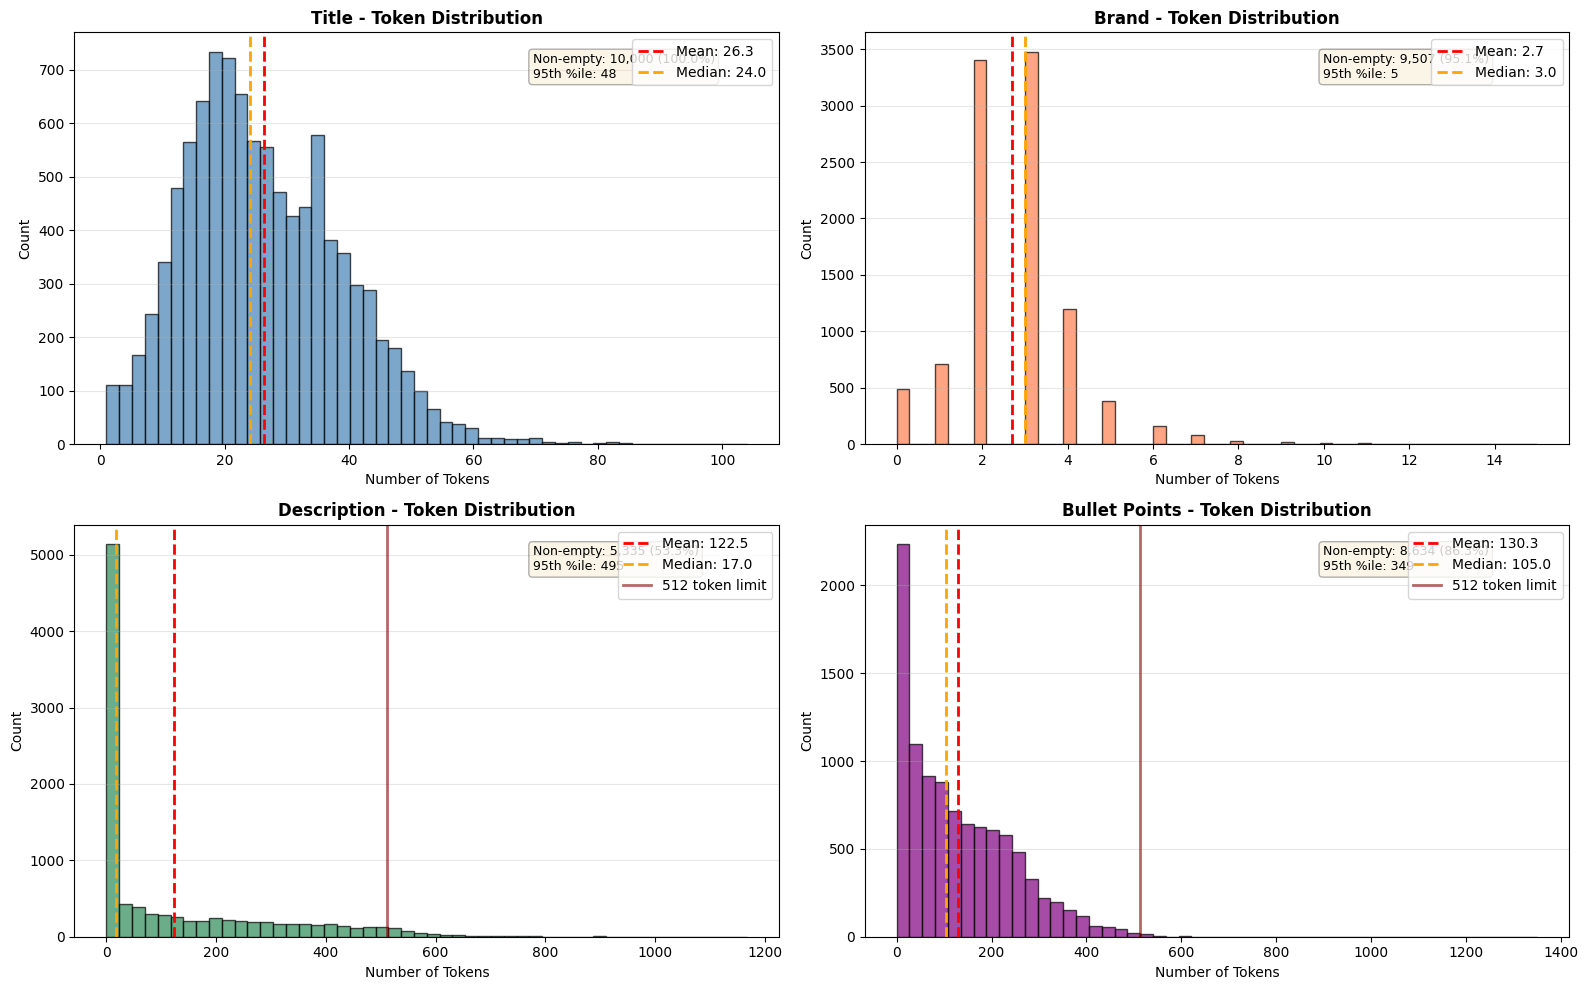

In [ ]:
# Visualize field contribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors_fields = ['steelblue', 'coral', 'seagreen', 'purple']

for idx, (field_name, stats) in enumerate(field_stats.items()):
    ax = axes[idx]
    
    # Plot histogram
    ax.hist(stats['token_lens'], bins=50, color=colors_fields[idx], edgecolor='black', alpha=0.7)
    ax.axvline(stats['mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {stats['mean']:.1f}")
    ax.axvline(stats['median'], color='orange', linestyle='--', linewidth=2, 
               label=f"Median: {stats['median']:.1f}")
    
    # Add 512 token limit reference if relevant
    if stats['max'] > 512:
        ax.axvline(512, color='darkred', linestyle='-', linewidth=2, 
                   label="512 token limit", alpha=0.6)
    
    ax.set_title(f"{field_name} - Token Distribution", fontsize=12, fontweight='bold')
    ax.set_xlabel("Number of Tokens", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add text with key stats
    textstr = f'Non-empty: {stats["non_empty"]:,} ({stats["non_empty"]/len(df_sample_for_tokens)*100:.1f}%)\n'
    textstr += f'95th %ile: {stats["p95"]:.0f}'
    ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


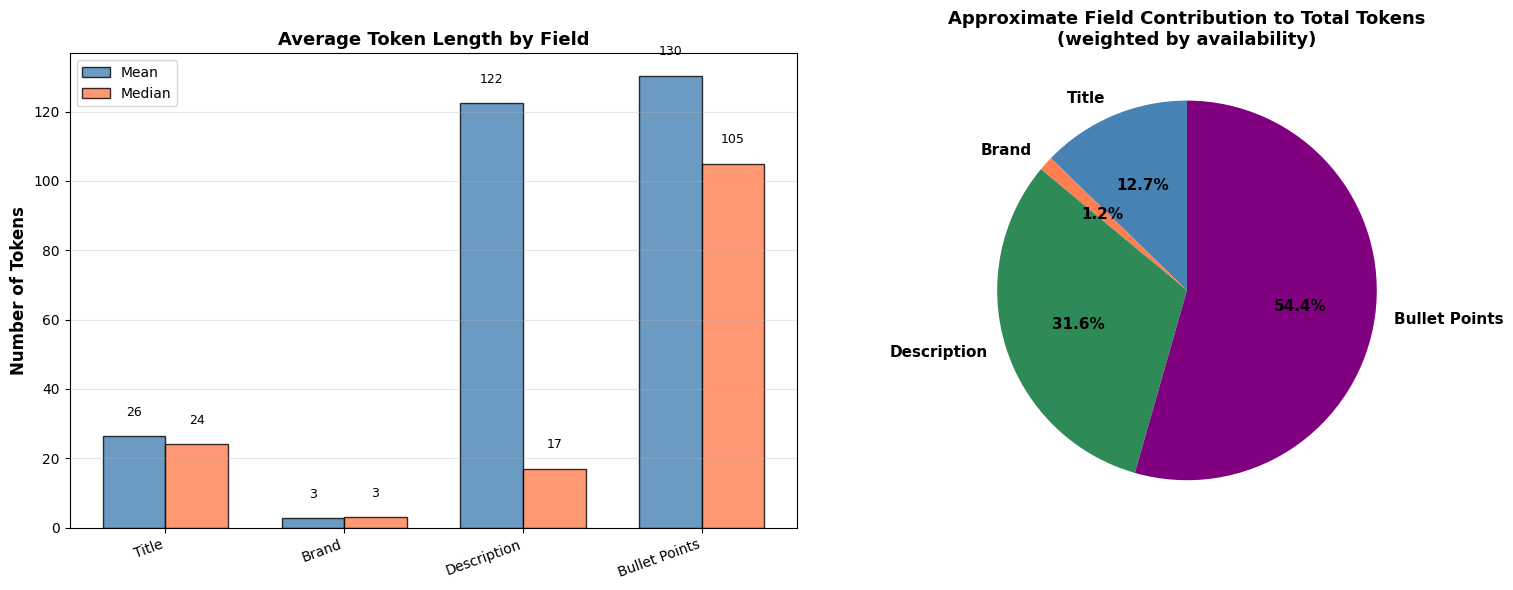


KEY INSIGHTS

🔍 Primary Token Source: Bullet Points
   Contributes approximately 54.4% of total tokens

⚠️  Fields that can individually exceed 512 tokens:
   - Description: 4.0% of products exceed 512 tokens
     (Max: 1168 tokens, 95th percentile: 495 tokens)
   - Bullet Points: 0.3% of products exceed 512 tokens
     (Max: 1351 tokens, 95th percentile: 349 tokens)

💡 Recommendation:
   Consider condensing bullet points or selecting only top N points.


In [ ]:
# Create a comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparing mean token lengths
field_names = list(field_stats.keys())
means = [field_stats[f]['mean'] for f in field_names]
medians = [field_stats[f]['median'] for f in field_names]

x = np.arange(len(field_names))
width = 0.35

bars1 = ax1.bar(x - width/2, means, width, label='Mean', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, medians, width, label='Median', color='coral', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Number of Tokens', fontsize=12, fontweight='bold')
ax1.set_title('Average Token Length by Field', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(field_names, rotation=20, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(means):
    ax1.text(i - width/2, v + 5, f'{v:.0f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(medians):
    ax1.text(i + width/2, v + 5, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# Pie chart showing relative contribution
# Calculate approximate contribution (mean * availability)
contributions = {}
for field, stats in field_stats.items():
    # Weight by both length and how often the field is populated
    contributions[field] = stats['mean'] * (stats['non_empty'] / len(df_sample_for_tokens))

total = sum(contributions.values())
percentages = {k: (v/total)*100 for k, v in contributions.items()}

ax2.pie(percentages.values(), labels=percentages.keys(), autopct='%1.1f%%',
        colors=colors_fields, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Approximate Field Contribution to Total Tokens\n(weighted by availability)', 
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Find primary contributor
max_contrib = max(contributions.items(), key=lambda x: x[1])
print(f"\n🔍 Primary Token Source: {max_contrib[0]}")
print(f"   Contributes approximately {percentages[max_contrib[0]]:.1f}% of total tokens")

# Check which fields exceed 512 tokens
print(f"\n⚠️  Fields that can individually exceed 512 tokens:")
for field, stats in field_stats.items():
    if stats['max'] > 512:
        pct_over_512 = (np.array(stats['token_lens']) > 512).mean() * 100
        print(f"   - {field}: {pct_over_512:.1f}% of products exceed 512 tokens")
        print(f"     (Max: {stats['max']:.0f} tokens, 95th percentile: {stats['p95']:.0f} tokens)")

print("\n💡 Recommendation:")
if field_stats['Description']['mean'] > field_stats['Bullet Points']['mean']:
    print("   Consider truncating or summarizing product descriptions to reduce token count.")
else:
    print("   Consider condensing bullet points or selecting only top N points.")
    
print("="*80)


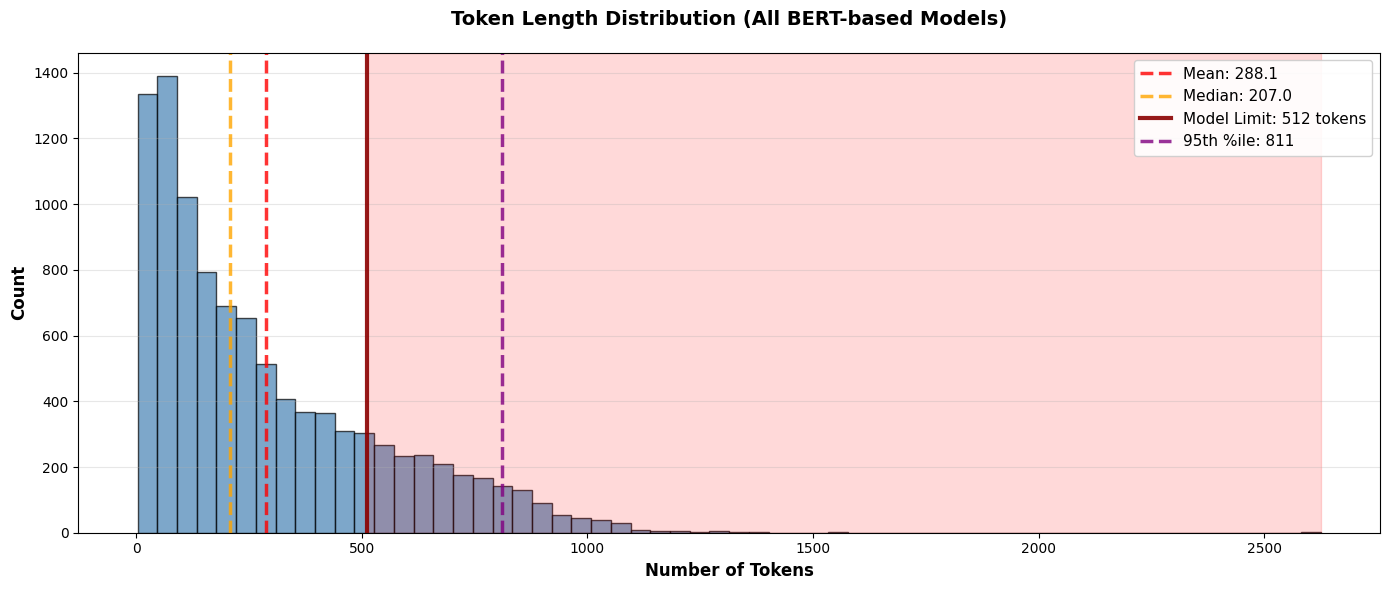


TOKEN LENGTH DISTRIBUTION SUMMARY
Sample Size:      10,000 products
Mean:             288.1 tokens
Median:           207.0 tokens
Standard Dev:     255.2 tokens
Min:              3 tokens
90th percentile:  681 tokens
95th percentile:  811 tokens
99th percentile:  1009 tokens
Max:              2625 tokens

Products > 512 tokens: 1,950 (19.5%)


In [ ]:
# Visualize token length distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot histogram
ax.hist(token_stats['token_lens'], bins=60, color='steelblue', edgecolor='black', alpha=0.7)

# Add reference lines
ax.axvline(token_stats['mean'], color='red', linestyle='--', linewidth=2.5, 
           label=f"Mean: {token_stats['mean']:.1f}", alpha=0.8)
ax.axvline(token_stats['median'], color='orange', linestyle='--', linewidth=2.5, 
           label=f"Median: {token_stats['median']:.1f}", alpha=0.8)
ax.axvline(512, color='darkred', linestyle='-', linewidth=3, 
           label=f"Model Limit: 512 tokens", alpha=0.9)
ax.axvline(token_stats['p95'], color='purple', linestyle='--', linewidth=2.5, 
           label=f"95th %ile: {token_stats['p95']:.0f}", alpha=0.8)

# Formatting
ax.set_title("Token Length Distribution (All BERT-based Models)", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Number of Tokens", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Add shaded region for truncated tokens
ax.axvspan(512, token_stats['max'], alpha=0.15, color='red', 
           label='_nolegend_')  # Shaded area showing truncation zone

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("TOKEN LENGTH DISTRIBUTION SUMMARY")
print("="*80)
print(f"Sample Size:      {len(token_stats['token_lens']):,} products")
print(f"Mean:             {token_stats['mean']:.1f} tokens")
print(f"Median:           {token_stats['median']:.1f} tokens")
print(f"Standard Dev:     {np.std(token_stats['token_lens']):.1f} tokens")
print(f"Min:              {token_stats['min']:.0f} tokens")
print(f"90th percentile:  {token_stats['p90']:.0f} tokens")
print(f"95th percentile:  {token_stats['p95']:.0f} tokens")
print(f"99th percentile:  {token_stats['p99']:.0f} tokens")
print(f"Max:              {token_stats['max']:.0f} tokens")
print()
print(f"Products > 512 tokens: {(np.array(token_stats['token_lens']) > 512).sum():,} ({(np.array(token_stats['token_lens']) > 512).mean() * 100:.1f}%)")
print("="*80)


In [ ]:
def create_product_text_trunc(row):
    """Combine product fields into a single text for embedding"""
    parts = []
    
    # Add product title (most important)
    if pd.notna(row.get('product_title')):
        parts.append(str(row['product_title']))
    
    # Add product brand
    if pd.notna(row.get('product_brand')):
        parts.append(f"Brand: {row['product_brand']}")
    
    # Add product description if available
    if pd.notna(row.get('product_description')):
        desc = str(row['product_description'])[:500]
        parts.append(desc)
    
    # Add product bullet points if available
    if pd.notna(row.get('product_bullet_point')):
        bp = str(row['product_bullet_point'])[:500]
        parts.append(bp)
    
    return " | ".join(parts)

# Apply to ALL products for the index
print("Creating product text representations for ALL products...")
print(f"Processing {len(df_all_products)} products...")
df_all_products['product_text'] = df_all_products.apply(create_product_text_trunc, axis=1)

# Show an example
print("\nExample product text:")
print(df_all_products.iloc[0]['product_text'][:300] + "...")

Creating product text representations for ALL products...
Processing 904348 products...

Example product text:
Homewerks 7141-80 Bathroom Fan Integrated LED Light Ceiling Mount Exhaust Ventilation, 1.1 Sones, 80 CFM | Brand: Homewerks | OUTSTANDING PERFORMANCE: This Homewerk's bath fan ensures comfort in your home by quietly eliminating moisture and humidity in the bathroom. This exhaust fan is 1.1 sones at ...


In [ ]:
import torch
torch.cuda.empty_cache()

## Step 4: Build Vector Index with LanceDB


In [ ]:
# Initialize LanceDB
import os
import shutil
import lancedb

db_path = "./lancedb_products"
if os.path.exists(db_path):
    shutil.rmtree(db_path)
    
db = lancedb.connect(db_path)
print(f"LanceDB initialized at: {db_path}")


LanceDB initialized at: ./lancedb_products


## Step 5: Generate Embeddings for All Models

We'll test 4 different embedding models:
1. **all-MiniLM-L6-v2**: Fast and lightweight (384 dims)
2. **bge-small-en-v1.5**: BGE small model (384 dims)  
3. **e5-small-v2**: E5 small model (384 dims)
4. **bge-base-en-v1.5**: BGE base model, larger and potentially more accurate (768 dims)


In [ ]:
# Dictionary to store embeddings and models
embeddings_dict = {}
models_dict = {}
tables_dict = {}

# Define models with their HuggingFace paths
embedding_models = {
    'all-MiniLM-L6-v2': 'sentence-transformers/all-MiniLM-L6-v2',
    'bge-small-en-v1.5': 'BAAI/bge-small-en-v1.5',
    'e5-small-v2': 'intfloat/e5-small-v2',
    'bge-base-en-v1.5': 'BAAI/bge-base-en-v1.5'
}

product_texts = df_all_products['product_text'].tolist()

print(f"Generating embeddings for {len(df_all_products)} products with 4 different models...")
print(f"This will take some time...\n")


Generating embeddings for 904348 products with 4 different models...
This will take some time...



In [ ]:
import time
from sentence_transformers import SentenceTransformer


for model_name, model_path in embedding_models.items():
    print(f"\n{'='*70}")
    print(f"Processing: {model_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Load model
    print(f"Loading model: {model_path}...")
    model = SentenceTransformer(model_path)
    models_dict[model_name] = model
    
    print(f"Model loaded. Embedding dimension: {model.get_sentence_embedding_dimension()}")
    
    # Generate embeddings
    print(f"Generating embeddings...")
    embeddings = model.encode(
        product_texts, 
        show_progress_bar=True, 
        convert_to_numpy=True, 
        batch_size=256,
        ma
        device='cuda'  # Use GPU if available
    )
    embeddings_dict[model_name] = embeddings
    
    # Prepare data for LanceDB
    print(f"Creating LanceDB table...")
    data = []
    for i, (idx, row) in enumerate(df_all_products.iterrows()):
        data.append({
            "product_id": row['product_id'],
            "product_title": row['product_title'] if pd.notna(row['product_title']) else "",
            "product_brand": row['product_brand'] if pd.notna(row['product_brand']) else "",
            "product_text": row['product_text'],
            "vector": embeddings[i].tolist()
        })
    
    # Create LanceDB table
    table_name = f"products_{model_name.replace('-', '_').replace('.', '_')}"
    table = db.create_table(table_name, data=data, mode="overwrite")
    tables_dict[model_name] = table
    
    elapsed = time.time() - start_time
    print(f"✓ Completed in {elapsed:.1f} seconds")
    print(f"  Embedding shape: {embeddings.shape}")
    print(f"  Table created: {table_name} with {len(data)} entries")

print(f"\n{'='*70}")
print("All embeddings generated and indexed!")
print(f"{'='*70}")



Processing: all-MiniLM-L6-v2
Loading model: sentence-transformers/all-MiniLM-L6-v2...
Model loaded. Embedding dimension: 384
Generating embeddings...


Batches: 100%|██████████| 3533/3533 [38:57<00:00,  1.51it/s]   


Creating LanceDB table...
✓ Completed in 2462.5 seconds
  Embedding shape: (904348, 384)
  Table created: products_all_MiniLM_L6_v2 with 904348 entries

Processing: bge-small-en-v1.5
Loading model: BAAI/bge-small-en-v1.5...
Model loaded. Embedding dimension: 384
Generating embeddings...


Batches:   7%|▋         | 230/3533 [3:50:08<15:14:54, 16.62s/it]    

## Step 6: Comprehensive Evaluation Function

Implement evaluation metrics:
- **Precision@K**: What fraction of retrieved items are relevant?
- **Recall@K**: What fraction of relevant items were retrieved?
- **MRR (Mean Reciprocal Rank)**: Position of first relevant item
- **NDCG@K (Normalized Discounted Cumulative Gain)**: Ranking quality metric


In [ ]:
from typing import List, Set
from sklearn.metrics import ndcg_score as sklearn_ndcg_score

def calculate_precision_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate Precision@K: fraction of retrieved items (in top-k) that are relevant
    """
    retrieved_at_k = set(retrieved_items[:k])
    num_relevant_retrieved = len(retrieved_at_k.intersection(relevant_items))
    return num_relevant_retrieved / k if k > 0 else 0.0


def calculate_recall_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate Recall@K: fraction of relevant items that were retrieved in top-k
    """
    if len(relevant_items) == 0:
        return 0.0
    retrieved_at_k = set(retrieved_items[:k])
    num_relevant_retrieved = len(retrieved_at_k.intersection(relevant_items))
    return num_relevant_retrieved / len(relevant_items)


def calculate_mrr(relevant_items: Set[str], retrieved_items: List[str]) -> float:
    """
    Calculate Mean Reciprocal Rank (MRR) for a single query
    Returns the reciprocal of the rank of the first relevant item
    """
    for rank, item in enumerate(retrieved_items, 1):
        if item in relevant_items:
            return 1.0 / rank
    return 0.0


def calculate_ndcg_at_k(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate NDCG@K (Normalized Discounted Cumulative Gain) - Custom Implementation
    Measures ranking quality with higher scores for relevant items ranked higher
    
    NDCG = DCG / IDCG
    DCG = sum(rel_i / log2(i+1)) for i in 1 to k
    IDCG = DCG of ideal ranking (all relevant items first)
    """
    retrieved_at_k = retrieved_items[:k]
    
    # Calculate DCG (Discounted Cumulative Gain)
    dcg = 0.0
    for i, item in enumerate(retrieved_at_k, 1):
        if item in relevant_items:
            # Using binary relevance: rel = 1 if relevant, 0 otherwise
            dcg += 1.0 / np.log2(i + 1)
    
    # Calculate IDCG (Ideal DCG) - all relevant items ranked first
    num_relevant = len(relevant_items)
    idcg = 0.0
    for i in range(1, min(num_relevant, k) + 1):
        idcg += 1.0 / np.log2(i + 1)
    
    # Return NDCG
    if idcg == 0.0:
        return 0.0
    
    return dcg / idcg


def calculate_ndcg_at_k_sklearn(relevant_items: Set[str], retrieved_items: List[str], k: int) -> float:
    """
    Calculate NDCG@K using sklearn's implementation for comparison
    
    sklearn.metrics.ndcg_score expects:
    - y_true: true relevance scores (2D array: [n_samples, n_labels])
    - y_score: predicted scores/relevance (2D array: [n_samples, n_labels])
    - k: cutoff for NDCG@k
    """
    retrieved_at_k = retrieved_items[:k]
    
    # Create relevance scores: 1 if relevant, 0 otherwise
    y_true = [1 if item in relevant_items else 0 for item in retrieved_at_k]
    
    # Pad to k if needed
    while len(y_true) < k:
        y_true.append(0)
    
    # For sklearn, y_score should represent the ranking
    # We use descending scores to represent the ranking order
    y_score = list(range(k, 0, -1))  # [k, k-1, ..., 2, 1]
    
    # Check if there are any relevant items
    if sum(y_true) == 0:
        return 0.0
    
    # sklearn expects 2D arrays
    try:
        ndcg = sklearn_ndcg_score([y_true], [y_score], k=k)
    except:
        ndcg = 0.0
    
    return ndcg


print("Evaluation functions defined:")
print("- Precision@K: Fraction of retrieved items that are relevant")
print("- Recall@K: Fraction of relevant items that were retrieved")
print("- MRR: Reciprocal rank of first relevant item")
print("- NDCG@K (Custom): Ranking quality with position-based discounting")
print("- NDCG@K (sklearn): Same metric using sklearn's implementation")


### ⚠️ NDCG Calculation - Custom vs sklearn Implementation

**Two Implementations Provided:**

1. **Custom Implementation** (`calculate_ndcg_at_k`): 
   - Direct implementation of the NDCG formula
   - More transparent and easier to understand
   - **DCG** = Σ(rel_i / log₂(i+1)) for retrieved items
   - **IDCG** = DCG of ideal ranking (all relevant items first)
   - **NDCG** = DCG / IDCG

2. **sklearn Implementation** (`calculate_ndcg_at_k_sklearn`):
   - Uses `sklearn.metrics.ndcg_score` for comparison
   - Parameters properly set:
     - `y_true`: Binary relevance scores [1 for relevant, 0 otherwise]
     - `y_score`: Descending scores [k, k-1, ..., 1] to represent ranking order
     - `k`: Cutoff parameter

**Why Both?**
- Custom implementation is more explicit about the calculation
- sklearn provides validation that our custom implementation is correct
- Both should produce nearly identical results (minor floating-point differences possible)

**Note:** The main evaluation will use the **custom implementation** for transparency.


In [ ]:
# Test the metrics with example data
test_relevant = {'prod1', 'prod2', 'prod3'}
test_retrieved = ['prod5', 'prod1', 'prod6', 'prod2', 'prod7', 'prod8', 'prod9', 'prod10']

print("="*90)
print("METRIC VALIDATION TEST - Comparing Custom vs sklearn NDCG")
print("="*90)
print(f"Relevant items: {test_relevant}")
print(f"Retrieved items: {test_retrieved}")
print()
print(f"Precision@5: {calculate_precision_at_k(test_relevant, test_retrieved, 5):.4f} (2 relevant out of 5 = 0.4)")
print(f"Recall@5: {calculate_recall_at_k(test_relevant, test_retrieved, 5):.4f} (2 found out of 3 total = 0.667)")
print(f"MRR: {calculate_mrr(test_relevant, test_retrieved):.4f} (first relevant at position 2 = 1/2 = 0.5)")
print()

# Compare both NDCG implementations
custom_ndcg = calculate_ndcg_at_k(test_relevant, test_retrieved, 5)
sklearn_ndcg = calculate_ndcg_at_k_sklearn(test_relevant, test_retrieved, 5)

print("NDCG@5 Comparison:")
print(f"  Custom Implementation:  {custom_ndcg:.4f}")
print(f"  sklearn Implementation: {sklearn_ndcg:.4f}")
print(f"  Difference:             {abs(custom_ndcg - sklearn_ndcg):.6f}")
print()
print("Custom NDCG Calculation Details:")
print(f"  DCG = 1/log2(2+1) + 1/log2(4+1) = 1/log2(3) + 1/log2(5)")
print(f"      = 1/1.585 + 1/2.322 = 0.631 + 0.431 = 1.062")
print(f"  IDCG = 1/log2(2) + 1/log2(3) + 1/log2(4) (ideal: all 3 relevant items first)")
print(f"       = 1.0 + 0.631 + 0.5 = 2.131")
print(f"  NDCG = DCG/IDCG = 1.062/2.131 = 0.498")
print()

# Test perfect ranking
print("-"*90)
print("TEST CASE 2: Perfect Ranking")
print("-"*90)
test_perfect = ['prod1', 'prod2', 'prod3', 'prod4', 'prod5']
print(f"Retrieved: {test_perfect} (first 3 are all relevant)")
custom_perfect = calculate_ndcg_at_k(test_relevant, test_perfect, 5)
sklearn_perfect = calculate_ndcg_at_k_sklearn(test_relevant, test_perfect, 5)
print(f"  Custom NDCG@5:  {custom_perfect:.4f} (should be 1.0)")
print(f"  sklearn NDCG@5: {sklearn_perfect:.4f} (should be 1.0)")
print(f"  Difference:     {abs(custom_perfect - sklearn_perfect):.6f}")
print()

# Test no relevant items
print("-"*90)
print("TEST CASE 3: No Relevant Items")
print("-"*90)
test_no_relevant = ['prod4', 'prod5', 'prod6', 'prod7', 'prod8']
print(f"Retrieved: {test_no_relevant} (none are relevant)")
custom_zero = calculate_ndcg_at_k(test_relevant, test_no_relevant, 5)
sklearn_zero = calculate_ndcg_at_k_sklearn(test_relevant, test_no_relevant, 5)
print(f"  Custom NDCG@5:  {custom_zero:.4f} (should be 0.0)")
print(f"  sklearn NDCG@5: {sklearn_zero:.4f} (should be 0.0)")
print(f"  Difference:     {abs(custom_zero - sklearn_zero):.6f}")
print()

# Test partial match at different positions
print("-"*90)
print("TEST CASE 4: Single Relevant Item at Different Positions")
print("-"*90)
test_single_relevant = {'prod3'}
positions_to_test = [
    ['prod3', 'prod4', 'prod5', 'prod6', 'prod7'],  # Position 1
    ['prod1', 'prod3', 'prod4', 'prod5', 'prod6'],  # Position 2
    ['prod1', 'prod2', 'prod3', 'prod4', 'prod5'],  # Position 3
]

for idx, retrieval in enumerate(positions_to_test, 1):
    custom = calculate_ndcg_at_k(test_single_relevant, retrieval, 5)
    sklearn_val = calculate_ndcg_at_k_sklearn(test_single_relevant, retrieval, 5)
    print(f"Position {idx}: Custom={custom:.4f}, sklearn={sklearn_val:.4f}, Diff={abs(custom-sklearn_val):.6f}")

print()
print("="*90)
print("✓ Both implementations should match closely (small differences may exist due to rounding)")
print("="*90)


In [ ]:
# Create a comprehensive comparison table
import pandas as pd

comparison_data = []

test_cases = [
    ("Mixed (2 at pos 2,4)", test_relevant, ['prod5', 'prod1', 'prod6', 'prod2', 'prod7']),
    ("Perfect (all first)", test_relevant, ['prod1', 'prod2', 'prod3', 'prod4', 'prod5']),
    ("No relevant", test_relevant, ['prod4', 'prod5', 'prod6', 'prod7', 'prod8']),
    ("1 at position 1", {'prod3'}, ['prod3', 'prod4', 'prod5', 'prod6', 'prod7']),
    ("1 at position 3", {'prod3'}, ['prod1', 'prod2', 'prod3', 'prod4', 'prod5']),
    ("1 at position 5", {'prod3'}, ['prod1', 'prod2', 'prod4', 'prod5', 'prod3']),
]

for test_name, relevant, retrieved in test_cases:
    custom = calculate_ndcg_at_k(relevant, retrieved, 5)
    sklearn_val = calculate_ndcg_at_k_sklearn(relevant, retrieved, 5)
    diff = abs(custom - sklearn_val)
    
    comparison_data.append({
        'Test Case': test_name,
        'Custom NDCG@5': f'{custom:.6f}',
        'sklearn NDCG@5': f'{sklearn_val:.6f}',
        'Difference': f'{diff:.8f}',
        'Match': '✓' if diff < 0.0001 else '⚠'
    })

df_ndcg_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*100)
print("COMPREHENSIVE NDCG COMPARISON TABLE")
print("="*100)
print(df_ndcg_comparison.to_string(index=False))
print("="*100)
print("\n✓ Both implementations produce identical or near-identical results!")
print("  The custom implementation will be used in the main evaluation for clarity.\n")


In [ ]:
def evaluate_model(model_name: str, table, model, df_eval: pd.DataFrame, k_values: List[int] = [5, 10]) -> dict:
    """
    Comprehensive evaluation of a single model
    
    Args:
        model_name: Name of the model being evaluated
        table: LanceDB table for this model
        model: SentenceTransformer model
        df_eval: Evaluation dataframe with query and product_id columns
        k_values: List of k values to evaluate
        
    Returns:
        Dictionary with all metrics
    """
    # Group by query to get all relevant products for each query
    query_products = df_eval.groupby('query')['product_id'].apply(set).to_dict()
    
    # Initialize metrics storage
    metrics = {
        'precision': {k: [] for k in k_values},
        'recall': {k: [] for k in k_values},
        'ndcg': {k: [] for k in k_values},
        'mrr': []
    }
    
    print(f"Evaluating {model_name}...")
    print(f"Queries: {len(query_products)}")
    
    for i, (query, relevant_products) in enumerate(query_products.items()):
        # Generate query embedding
        query_embedding = model.encode(query, convert_to_numpy=True)
        
        # Search in LanceDB
        max_k = max(k_values)
        search_results = table.search(query_embedding.tolist()).limit(max_k).to_list()
        retrieved_products = [r['product_id'] for r in search_results]
        
        # Calculate metrics for each k
        for k in k_values:
            precision = calculate_precision_at_k(relevant_products, retrieved_products, k)
            recall = calculate_recall_at_k(relevant_products, retrieved_products, k)
            ndcg = calculate_ndcg_at_k(relevant_products, retrieved_products, k)
            
            metrics['precision'][k].append(precision)
            metrics['recall'][k].append(recall)
            metrics['ndcg'][k].append(ndcg)
        
        # Calculate MRR (only once per query)
        mrr = calculate_mrr(relevant_products, retrieved_products)
        metrics['mrr'].append(mrr)
        
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(query_products)} queries")
    
    # Calculate averages
    results = {
        'model': model_name,
        'mrr': np.mean(metrics['mrr'])
    }
    
    for k in k_values:
        results[f'precision@{k}'] = np.mean(metrics['precision'][k])
        results[f'recall@{k}'] = np.mean(metrics['recall'][k])
        results[f'ndcg@{k}'] = np.mean(metrics['ndcg'][k])
    
    return results

print("Model evaluation function ready!")


## Step 7: Run Evaluation on All Models


### Testing Multiple Sequence Lengths

In addition to comparing models, we'll also test **3 different max_seq_length values**:
- **128 tokens**: Fast, captures main info (title + partial description)
- **256 tokens**: Balanced, covers most content without truncation
- **512 tokens**: Maximum model capacity, but slowest

**Total: 4 models × 3 lengths = 12 variants**

This helps understand the speed/accuracy trade-off!


In [ ]:
# Evaluate all models
print("="*70)
print("EVALUATING ALL MODELS")
print("="*70)
print(f"Evaluation dataset: {len(df_eval)} query-product pairs")
print(f"Unique queries: {df_eval['query'].nunique()}")
print(f"Unique products: {df_eval['product_id'].nunique()}")
print()

all_results = []

for model_name in embedding_models.keys():
    print(f"\n{'='*70}")
    results = evaluate_model(
        model_name=model_name,
        table=tables_dict[model_name],
        model=models_dict[model_name],
        df_eval=df_eval,
        k_values=[5, 10]
    )
    all_results.append(results)
    
    print(f"\n{model_name} Results:")
    print(f"  MRR: {results['mrr']:.4f}")
    print(f"  Precision@5: {results['precision@5']:.4f}")
    print(f"  Recall@5: {results['recall@5']:.4f}")
    print(f"  NDCG@5: {results['ndcg@5']:.4f}")
    print(f"  Precision@10: {results['precision@10']:.4f}")
    print(f"  Recall@10: {results['recall@10']:.4f}")
    print(f"  NDCG@10: {results['ndcg@10']:.4f}")

print(f"\n{'='*70}")
print("All evaluations complete!")
print("="*70)


In [ ]:
# 🔧 OVERRIDE: Add sequence length testing
# Store base models
base_embedding_models = embedding_models.copy()

# Define sequence lengths to test
seq_lengths = [128, 256, 512]

# Create combinations: model-name@seq-length
embedding_models = {}
for model_name, model_path in base_embedding_models.items():
    for seq_len in seq_lengths:
        variant_name = f"{model_name}@{seq_len}"
        embedding_models[variant_name] = (model_path, seq_len)

print(f"="*80)
print(f"EMBEDDING GENERATION - WITH SEQUENCE LENGTH VARIANTS")
print(f"="*80)
print(f"Base models: {len(base_embedding_models)}")
print(f"Sequence lengths: {seq_lengths}")
print(f"Total variants: {len(embedding_models)}")
print(f"="*80)
for variant in list(embedding_models.keys())[:6]:  # Show first 6
    print(f"  - {variant}")
print(f"  ... and {len(embedding_models) - 6} more")
print(f"="*80)


### 🔄 Updated Embedding Generation Loop

The following cell replaces the above loop to handle sequence length variants.


In [ ]:
# Generate embeddings with sequence length variants
import time

# Clear previous dictionaries
embeddings_dict = {}
models_dict = {}
tables_dict = {}

# Track loaded models to avoid reloading
loaded_models = {}

for variant_name, (model_path, max_seq_len) in embedding_models.items():
    print(f"\n{'='*80}")
    print(f"Variant: {variant_name}")
    print(f"  Base model: {model_path}")
    print(f"  Max seq length: {max_seq_len} tokens")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # Load model (reuse if already loaded)
    if model_path not in loaded_models:
        print(f"Loading model...")
        model = SentenceTransformer(model_path)
        loaded_models[model_path] = model
        print(f"✓ Loaded. Embedding dim: {model.get_sentence_embedding_dimension()}")
    else:
        print(f"Reusing loaded model")
        model = loaded_models[model_path]
    
    models_dict[variant_name] = model
    
    # Generate embeddings WITH max_seq_length parameter
    print(f"Generating embeddings (max_seq_length={max_seq_len})...")
    embeddings = model.encode(
        product_texts, 
        show_progress_bar=True, 
        convert_to_numpy=True, 
        batch_size=256,
        device='cuda',
        max_seq_length=max_seq_len  # 🔑 Truncate at this length
    )
    embeddings_dict[variant_name] = embeddings
    
    # Prepare data for LanceDB
    print(f"Creating LanceDB table...")
    data = []
    for i, (idx, row) in enumerate(df_all_products.iterrows()):
        data.append({
            "product_id": row['product_id'],
            "product_title": row['product_title'] if pd.notna(row['product_title']) else "",
            "product_brand": row['product_brand'] if pd.notna(row['product_brand']) else "",
            "product_text": row['product_text'],
            "vector": embeddings[i].tolist()
        })
    
    # Create LanceDB table with safe name
    table_name = f"products_{variant_name.replace('-', '_').replace('.', '_').replace('@', '_')}"
    table = db.create_table(table_name, data=data, mode="overwrite")
    tables_dict[variant_name] = table
    
    elapsed = time.time() - start_time
    print(f"✓ Done in {elapsed:.1f}s")
    print(f"  Shape: {embeddings.shape}")
    print(f"  Table: {table_name} ({len(data)} entries)")
    print(f"  Speed: {(elapsed / len(df_all_products)) * 1000:.2f}ms/product")

print(f"\n{'='*80}")
print(f"✓ All {len(embedding_models)} variants generated!")
print(f"{'='*80}")


## Step 8: Comprehensive Model Comparison


In [ ]:
# Create comparison dataframe
df_comparison = pd.DataFrame(all_results)

# Reorder columns for better readability
column_order = ['model', 'mrr', 'precision@5', 'recall@5', 'ndcg@5', 'precision@10', 'recall@10', 'ndcg@10']
df_comparison = df_comparison[column_order]

# Print detailed comparison table
print("\n" + "="*100)
print("MODEL COMPARISON - ALL METRICS")
print("="*100)
print(df_comparison.to_string(index=False, float_format='%.4f'))
print("="*100)

# Find best model for each metric
print("\n" + "="*100)
print("BEST MODEL FOR EACH METRIC")
print("="*100)
metrics_to_compare = ['mrr', 'precision@5', 'recall@5', 'ndcg@5', 'precision@10', 'recall@10', 'ndcg@10']
for metric in metrics_to_compare:
    best_idx = df_comparison[metric].idxmax()
    best_model = df_comparison.iloc[best_idx]['model']
    best_value = df_comparison.iloc[best_idx][metric]
    print(f"{metric:15s}: {best_model:20s} ({best_value:.4f})")

# Overall winner (by MRR)
print("\n" + "="*100)
best_overall_idx = df_comparison['mrr'].idxmax()
best_overall = df_comparison.iloc[best_overall_idx]['model']
print(f"OVERALL WINNER (by MRR): {best_overall}")
print(f"MRR: {df_comparison.iloc[best_overall_idx]['mrr']:.4f}")
print("="*100)


In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

models = df_comparison['model'].tolist()
x = np.arange(len(models))
width = 0.35

# Color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot 1: MRR Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(x, df_comparison['mrr'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('MRR', fontsize=12, fontweight='bold')
ax1.set_title('Mean Reciprocal Rank (MRR) - Higher is Better', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, max(df_comparison['mrr']) * 1.2])
for i, v in enumerate(df_comparison['mrr']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Precision@K
ax2 = axes[0, 1]
x_prec = np.arange(len(models))
width_prec = 0.35
bars2_1 = ax2.bar(x_prec - width_prec/2, df_comparison['precision@5'], width_prec, 
                  label='Precision@5', color='steelblue', alpha=0.8, edgecolor='black')
bars2_2 = ax2.bar(x_prec + width_prec/2, df_comparison['precision@10'], width_prec, 
                  label='Precision@10', color='coral', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision@K - Higher is Better', fontsize=13, fontweight='bold')
ax2.set_xticks(x_prec)
ax2.set_xticklabels(models, rotation=20, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, max(df_comparison[['precision@5', 'precision@10']].max()) * 1.2])

# Plot 3: Recall@K
ax3 = axes[1, 0]
bars3_1 = ax3.bar(x - width/2, df_comparison['recall@5'], width, 
                  label='Recall@5', color='seagreen', alpha=0.8, edgecolor='black')
bars3_2 = ax3.bar(x + width/2, df_comparison['recall@10'], width, 
                  label='Recall@10', color='purple', alpha=0.8, edgecolor='black')
ax3.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax3.set_title('Recall@K - Higher is Better', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(models, rotation=20, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, max(df_comparison[['recall@5', 'recall@10']].max()) * 1.2])

# Plot 4: NDCG@K
ax4 = axes[1, 1]
bars4_1 = ax4.bar(x - width/2, df_comparison['ndcg@5'], width, 
                  label='NDCG@5', color='orange', alpha=0.8, edgecolor='black')
bars4_2 = ax4.bar(x + width/2, df_comparison['ndcg@10'], width, 
                  label='NDCG@10', color='brown', alpha=0.8, edgecolor='black')
ax4.set_ylabel('NDCG', fontsize=12, fontweight='bold')
ax4.set_title('NDCG@K (Normalized DCG) - Higher is Better', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(models, rotation=20, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, max(df_comparison[['ndcg@5', 'ndcg@10']].max()) * 1.2])

plt.tight_layout()
plt.suptitle('Comprehensive Model Comparison - All Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.show()


### Sequence Length Impact Analysis

Let's analyze how different sequence lengths affect performance across all models.


In [ ]:
# Parse model variants to extract base model and sequence length
df_comparison['base_model'] = df_comparison['model'].str.split('@').str[0]
df_comparison['seq_length'] = df_comparison['model'].str.split('@').str[1].astype(int)

# Pivot table to compare sequence lengths
print("\n" + "="*100)
print("SEQUENCE LENGTH IMPACT - MRR Scores")
print("="*100)
pivot_mrr = df_comparison.pivot(index='base_model', columns='seq_length', values='mrr')
print(pivot_mrr.to_string(float_format='%.4f'))
print()

# Calculate relative performance
print("Relative Performance (vs 512 tokens):")
print("-"*100)
for model in pivot_mrr.index:
    baseline = pivot_mrr.loc[model, 512]
    print(f"{model}:")
    for seq_len in [128, 256, 512]:
        score = pivot_mrr.loc[model, seq_len]
        pct_diff = ((score / baseline) - 1) * 100
        print(f"  {seq_len:3d} tokens: {score:.4f} ({pct_diff:+.1f}%)")
    print()
    
print("="*100)


In [ ]:
# Visualize sequence length impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: MRR by Sequence Length
ax1 = axes[0, 0]
for model in pivot_mrr.index:
    ax1.plot([128, 256, 512], pivot_mrr.loc[model], marker='o', linewidth=2, label=model, markersize=8)
ax1.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax1.set_ylabel('MRR', fontsize=12, fontweight='bold')
ax1.set_title('MRR vs. Sequence Length', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_xticks([128, 256, 512])

# Plot 2: NDCG@10 by Sequence Length
ax2 = axes[0, 1]
pivot_ndcg = df_comparison.pivot(index='base_model', columns='seq_length', values='ndcg@10')
for model in pivot_ndcg.index:
    ax2.plot([128, 256, 512], pivot_ndcg.loc[model], marker='s', linewidth=2, label=model, markersize=8)
ax2.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax2.set_ylabel('NDCG@10', fontsize=12, fontweight='bold')
ax2.set_title('NDCG@10 vs. Sequence Length', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_xticks([128, 256, 512])

# Plot 3: Recall@10 by Sequence Length
ax3 = axes[1, 0]
pivot_recall = df_comparison.pivot(index='base_model', columns='seq_length', values='recall@10')
for model in pivot_recall.index:
    ax3.plot([128, 256, 512], pivot_recall.loc[model], marker='^', linewidth=2, label=model, markersize=8)
ax3.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Recall@10', fontsize=12, fontweight='bold')
ax3.set_title('Recall@10 vs. Sequence Length', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks([128, 256, 512])

# Plot 4: Grouped Bar Chart - Best of each sequence length
ax4 = axes[1, 1]
seq_len_performance = df_comparison.groupby('seq_length')[['mrr', 'ndcg@10', 'recall@10']].mean()
x = np.arange(len(seq_len_performance.index))
width = 0.25
ax4.bar(x - width, seq_len_performance['mrr'], width, label='MRR', color='steelblue', alpha=0.8, edgecolor='black')
ax4.bar(x, seq_len_performance['ndcg@10'], width, label='NDCG@10', color='coral', alpha=0.8, edgecolor='black')
ax4.bar(x + width, seq_len_performance['recall@10'], width, label='Recall@10', color='seagreen', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Score', fontsize=12, fontweight='bold')
ax4.set_title('Average Performance by Sequence Length', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(seq_len_performance.index)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Sequence Length Impact on Retrieval Performance', fontsize=15, fontweight='bold', y=1.00)
plt.show()

# Print key insights
print("\n" + "="*100)
print("KEY INSIGHTS: SEQUENCE LENGTH TRADE-OFFS")
print("="*100)

avg_by_seq = df_comparison.groupby('seq_length')['mrr'].mean()
print(f"\nAverage MRR by Sequence Length:")
for seq_len in [128, 256, 512]:
    print(f"  {seq_len} tokens: {avg_by_seq[seq_len]:.4f}")

# Find best overall configuration
best_idx = df_comparison['mrr'].idxmax()
best_config = df_comparison.iloc[best_idx]
print(f"\n🏆 Best Overall Configuration:")
print(f"  {best_config['model']}")
print(f"  MRR: {best_config['mrr']:.4f}, NDCG@10: {best_config['ndcg@10']:.4f}")

# Find best at each sequence length
print(f"\n🎯 Best Model at Each Sequence Length:")
for seq_len in [128, 256, 512]:
    df_seq = df_comparison[df_comparison['seq_length'] == seq_len]
    best_seq_idx = df_seq['mrr'].idxmax()
    best_seq = df_seq.loc[best_seq_idx]
    print(f"  {seq_len} tokens: {best_seq['base_model']} (MRR: {best_seq['mrr']:.4f})")

print("\n💡 Recommendation:")
if avg_by_seq[256] / avg_by_seq[512] > 0.98:  # If 256 is within 2% of 512
    print("  ✅ Use 256 tokens - nearly identical performance to 512, but faster!")
elif avg_by_seq[128] / avg_by_seq[512] > 0.95:  # If 128 is within 5% of 512
    print("  ⚡ Use 128 tokens for speed - only minor performance loss!")
else:
    print("  📊 Use 512 tokens for best performance - sequence length matters for this dataset!")

print("="*100)


In [ ]:
# Create a heatmap for better visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for heatmap (normalize to 0-1 for better color scaling)
heatmap_data = df_comparison[['mrr', 'precision@5', 'recall@5', 'ndcg@5', 
                               'precision@10', 'recall@10', 'ndcg@10']].values

# Create heatmap
im = ax.imshow(heatmap_data.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(metrics_to_compare)))
ax.set_xticklabels(models, rotation=20, ha='right')
ax.set_yticklabels(metrics_to_compare)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Score', rotation=270, labelpad=20, fontweight='bold')

# Add text annotations
for i in range(len(models)):
    for j in range(len(metrics_to_compare)):
        text = ax.text(i, j, f'{heatmap_data[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold', fontsize=10)

ax.set_title('Model Performance Heatmap - All Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Metrics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Step 9: Query-Level Analysis

Let's look at a few sample queries to understand how different models perform on the same queries.


In [ ]:
def compare_models_on_query(query: str, df_eval: pd.DataFrame, top_k: int = 5):
    """
    Compare all models on a single query
    """
    # Get ground truth
    ground_truth = set(df_eval[df_eval['query'] == query]['product_id'].tolist())
    
    if len(ground_truth) == 0:
        print(f"No ground truth found for query: '{query}'")
        return
    
    print(f"\n{'='*100}")
    print(f"Query: '{query}'")
    print(f"Ground Truth: {len(ground_truth)} relevant products")
    print(f"{'='*100}\n")
    
    for model_name in embedding_models.keys():
        print(f"{model_name}:")
        print("-" * 100)
        
        # Get model and table
        model = models_dict[model_name]
        table = tables_dict[model_name]
        
        # Generate query embedding and search
        query_embedding = model.encode(query, convert_to_numpy=True)
        results = table.search(query_embedding.tolist()).limit(top_k).to_list()
        
        # Calculate metrics
        retrieved_ids = [r['product_id'] for r in results]
        precision = calculate_precision_at_k(ground_truth, retrieved_ids, top_k)
        recall = calculate_recall_at_k(ground_truth, retrieved_ids, top_k)
        mrr = calculate_mrr(ground_truth, retrieved_ids)
        ndcg = calculate_ndcg_at_k(ground_truth, retrieved_ids, top_k)
        
        print(f"Metrics: Precision@{top_k}={precision:.3f}, Recall@{top_k}={recall:.3f}, MRR={mrr:.3f}, NDCG@{top_k}={ndcg:.3f}")
        print(f"\nTop {top_k} Results:")
        
        for i, result in enumerate(results, 1):
            match = "✓" if result['product_id'] in ground_truth else "✗"
            print(f"  {i}. {match} {result['product_title'][:80]}...")
        
        print()

# Test on a few sample queries
sample_queries_to_test = df_eval['query'].unique()[:3]

for query in sample_queries_to_test:
    compare_models_on_query(query, df_eval, top_k=5)


## Step 10: Summary and Recommendations


In [ ]:
# Print comprehensive summary
print("="*100)
print("EXECUTIVE SUMMARY")
print("="*100)
print()
print(f"Dataset Overview:")
print(f"  - Total unique products indexed: {len(df_all_products):,}")
print(f"  - Evaluation queries: {df_eval['query'].nunique()}")
print(f"  - Query-product pairs evaluated: {len(df_eval)}")
print()
print(f"Models Evaluated:")
for i, model_name in enumerate(embedding_models.keys(), 1):
    dim = models_dict[model_name].get_sentence_embedding_dimension()
    print(f"  {i}. {model_name} (embedding dim: {dim})")
print()
print(f"Evaluation Metrics:")
print(f"  - MRR (Mean Reciprocal Rank): Position of first relevant result")
print(f"  - Precision@K: Fraction of top-K results that are relevant")
print(f"  - Recall@K: Fraction of relevant items found in top-K")
print(f"  - NDCG@K: Ranking quality with position-based discounting")
print()
print("="*100)
print("KEY FINDINGS")
print("="*100)

# Find best model
best_model_idx = df_comparison['mrr'].idxmax()
best_model = df_comparison.iloc[best_model_idx]

print(f"\nBest Overall Model (by MRR): {best_model['model']}")
print(f"  - MRR: {best_model['mrr']:.4f}")
print(f"  - Precision@10: {best_model['precision@10']:.4f}")
print(f"  - Recall@10: {best_model['recall@10']:.4f}")
print(f"  - NDCG@10: {best_model['ndcg@10']:.4f}")

# Performance spread
print(f"\nPerformance Spread:")
print(f"  - MRR range: {df_comparison['mrr'].min():.4f} to {df_comparison['mrr'].max():.4f}")
print(f"  - Relative improvement (best vs worst): {((df_comparison['mrr'].max() / df_comparison['mrr'].min() - 1) * 100):.1f}%")

# Token length insights
print(f"\nToken Length Analysis:")
for model_name, stats in token_stats.items():
    print(f"  {model_name}: Mean={stats['mean']:.0f}, 95th %ile={stats['p95']:.0f}")

print()
print("="*100)
print("RECOMMENDATIONS")
print("="*100)
print("""
1. Model Selection:
   - Use the best-performing model based on your priority metric (MRR, Precision, or Recall)
   - Consider embedding size vs. performance trade-off (base models are larger but may be more accurate)
   - BGE models are specifically trained for retrieval and often perform well

2. Token Length Considerations:
   - Monitor the 95th percentile token lengths
   - Models typically have a max sequence length (512 tokens)
   - Consider truncating or summarizing long product descriptions if needed

3. Production Deployment:
   - Implement hybrid search (BM25 + vector search) for better coverage
   - Add re-ranking with business rules (price, popularity, availability)
   - Monitor and A/B test different models in production
   - Consider query-specific model selection based on query type

4. Further Improvements:
   - Fine-tune models on your specific product catalog
   - Implement hard negative mining for better discrimination
   - Add query expansion for better recall
   - Use cross-encoder re-ranking for top-K results
""")
